# 고양이 강아지 구분
## CNN 이용
- 원래 데이터는 25,000개 (고양이 + 강아지)
- 여기서는 2000개로 학습을 시킨다
- 검증은 1000개의 이미지 사용 

## 데이터 다운로드

In [0]:
import os, os.path, shutil
import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
!ls sample_data/

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [3]:
if not os.path.exists("./data"):
    os.makedirs("./data")
if not os.path.exists("./data/cats_and_dogs_filtered.zip"):
  !wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./data/cats_and_dogs_filtered.zip

--2019-03-08 06:58:12--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./data/cats_and_dogs_filtered.zip’

./data/cats_and_dog 100%[===================>]  65.43M   188MB/s    in 0.3s    

2019-03-08 06:58:12 (188 MB/s) - ‘./data/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [6]:
!ls data

cats_and_dogs_filtered	cats_and_dogs_filtered.zip


In [0]:
local_zip = './data/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data')
zip_ref.close()

In [8]:
!ls data

cats_and_dogs_filtered	cats_and_dogs_filtered.zip


In [9]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 3s (14.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [10]:
!tree -d .

.
├── data
│   └── cats_and_dogs_filtered
│       ├── train
│       │   ├── cats
│       │   └── dogs
│       └── validation
│           ├── cats
│           └── dogs
└── sample_data

9 directories


In [0]:
#!ls ./data/cats_and_dogs_filtered/train/cats/

In [0]:
base_dir = './data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [12]:
train_cats_dir

'./data/cats_and_dogs_filtered/train/cats'

## 파일 확인

In [13]:
train_cat_fnames = os.listdir(train_cats_dir)
print train_cat_fnames[:10]

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print train_dog_fnames[:10]

['cat.386.jpg', 'cat.752.jpg', 'cat.251.jpg', 'cat.788.jpg', 'cat.706.jpg', 'cat.725.jpg', 'cat.358.jpg', 'cat.111.jpg', 'cat.200.jpg', 'cat.18.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [14]:
print 'total training cat images:', len(os.listdir(train_cats_dir))
print 'total training dog images:', len(os.listdir(train_dogs_dir))
print 'total validation cat images:', len(os.listdir(validation_cats_dir))
print 'total validation dog images:', len(os.listdir(validation_dogs_dir))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


## 이미지 샘플 확인

In [0]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

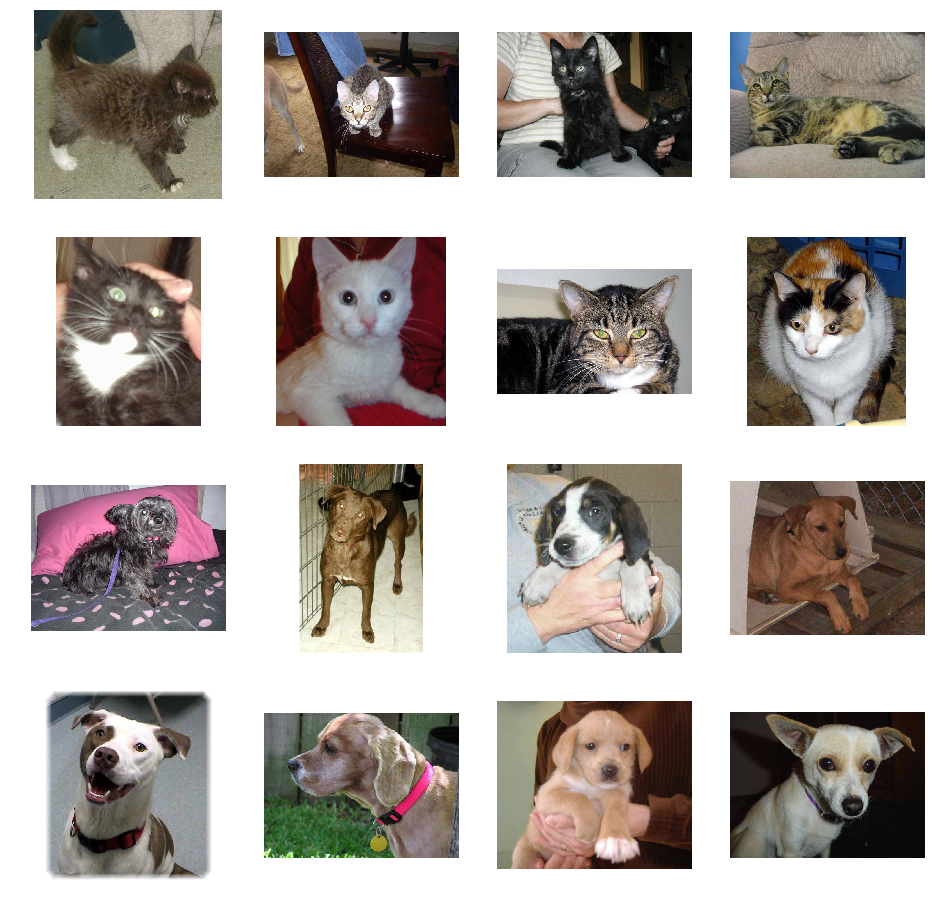

In [16]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## 간단한 CNN을 사용한 모델


In [17]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 

Using TensorFlow backend.


In [18]:
# from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
# from keras.layers import Dense, Activation, Dropout, Flatten


# 데이터 생성

img_width = 150
img_height = 150


datagen = ImageDataGenerator(rescale = 1./255)

# 이미지를 읽는 디렉토리: flow_from_directory()

train_generator = datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

validation_generator = datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)


# 모델

model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', 
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # binary 분류

model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)    

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4), #input size가 커서 lr이 높으면 발산
              metrics=['acc'])
print('starting training....')

# 데이터 준비와 훈련을 동시에 병행진행할 수 있다.
history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

print('training finished!!')
print('saving weights to simple_CNN.h5')

model.save_weights('simple_CNN.h5') # 현재 학습한 파라미터만 임시로 저장

print('all weights saved successfully !!')
#models.load_weights('models/simple_CNN.h5') # 초기값으로 넣고 돌리면 시간 save

starting training....
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 16s 164ms/step - loss: 0.6929 - acc: 0.5285 - val_loss: 0.6724 - val_acc: 0.6340
Epoch 2/30
100/100 [==============================] - 11s 114ms/step - loss: 0.6634 - acc: 0.6110 - val_loss: 0.6464 - val_acc: 0.6340
Epoch 3/30
100/100 [==============================] - 11s 114ms/step - loss: 0.6267 - acc: 0.6525 - val_loss: 0.6312 - val_acc: 0.6180
Epoch 4/30
100/100 [==============================] - 11s 115ms/step - loss: 0.5893 - acc: 0.6835 - val_loss: 0.5847 - val_acc: 0.7050
Epoch 5/30
100/100 [==============================] - 12s 115ms/step - loss: 0.5539 - acc: 0.7125 - val_loss: 0.5896 - val_acc: 0.6850
Epoch 6/30
100/100 [==============================] - 11s 114ms/step - loss: 0.5243 - acc: 0.7355 - val_loss: 0.5806 - val_acc: 0.7020
Epoch 7/30
100/100 [==============================] - 12s 116ms/step - loss: 0.4876 - acc: 0.7660 - val_loss: 0.5572 - v

## 성능 확인

Text(0.5,1,'Training and validation loss')

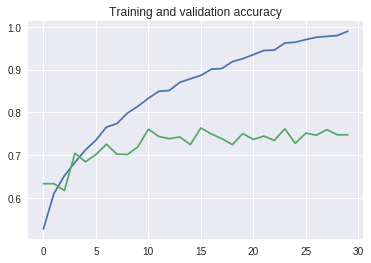

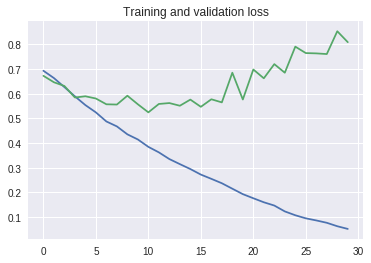

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

### 과대적합이 발생한 것을 알 수 있다.

In [0]:
!ls data

cats_and_dogs_filtered	cats_and_dogs_filtered.zip


# data augmentation과 드롭아웃 사용

In [0]:
datagen_2 = ImageDataGenerator(
  rotation_range = 20,
  width_shift_range = 0.2,
  height_shift_range = 0.1,
  shear_range=0.1,
  zoom_range=0.1,
  horizontal_flip = True,
  fill_mode = 'nearest')

In [0]:
fnames = sorted([os.path.join(train_cats_dir, fname) for
                fname in os.listdir(train_cats_dir)])

In [23]:
img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))
x=image.img_to_array(img)  # 넘파이 배열로 변환
print(x.shape)
x=x.reshape((1,)+x.shape)
print(x.shape)

(150, 150, 3)
(1, 150, 150, 3)


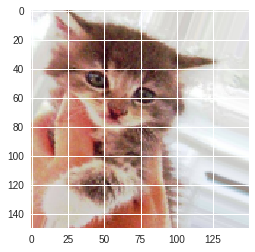

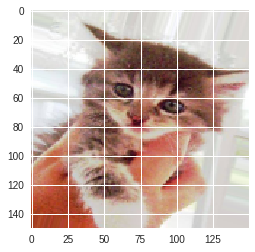

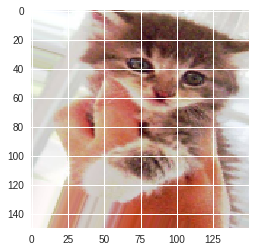

In [24]:
i=1
for batch in datagen_2.flow(x, batch_size=1):
    plt.figure(i)
    imgplot=plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i%4 == 0:
      break
plt.show() 

In [25]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True) # data augmentation

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
# 											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=32)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
# 											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=32)


# 모델(과대적합을 피하기 위하여 일반화, General, Regularlization)

model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', 
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


print('starting training....')
history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=50,#epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

print('training finished!!')

print('saving weights to Augment_CNN.h5')

model.save_weights('Augment_CNN.h5')

print('all weights saved successfully !!')
#models.load_weights('models/simple_CNN.h5')

starting training....
Epoch 1/50
100/100 [==============================] - 35s 348ms/step - loss: 0.6916 - acc: 0.5112 - val_loss: 0.6756 - val_acc: 0.5711
Epoch 2/50
100/100 [==============================] - 32s 318ms/step - loss: 0.6795 - acc: 0.5631 - val_loss: 0.7364 - val_acc: 0.4897
Epoch 3/50
100/100 [==============================] - 32s 320ms/step - loss: 0.6657 - acc: 0.5938 - val_loss: 0.6275 - val_acc: 0.6364
Epoch 4/50
100/100 [==============================] - 32s 318ms/step - loss: 0.6413 - acc: 0.6213 - val_loss: 0.6170 - val_acc: 0.6250
Epoch 5/50
100/100 [==============================] - 32s 322ms/step - loss: 0.6242 - acc: 0.6553 - val_loss: 0.5882 - val_acc: 0.6548
Epoch 6/50
100/100 [==============================] - 32s 320ms/step - loss: 0.6069 - acc: 0.6656 - val_loss: 0.5917 - val_acc: 0.6823
Epoch 7/50
100/100 [==============================] - 32s 315ms/step - loss: 0.6012 - acc: 0.6800 - val_loss: 0.5579 - val_acc: 0.7126
Epoch 8/50
100/100 [=============

KeyboardInterrupt: ignored

Text(0.5,1,u'Training and validation loss')

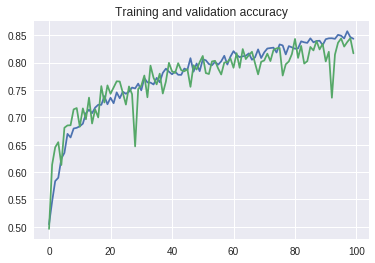

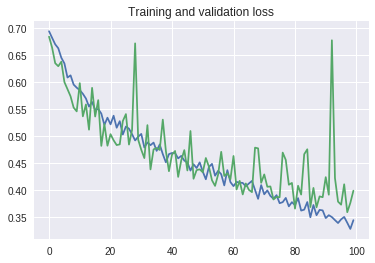

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [0]:
# 프로세스 강제 종료 방법
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)